# Project 1, Part 5, Data Visualization



# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd

import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)
    

In [3]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# 1.5 Example of a Data Visualization created using Python

The data science team would like for you to create an example of a data visualization using Python from data in a Pandas dataframe containing data from an SQL query.

Write 1 and only 1 query.  Note that the query may have as many subqueries, including "with" clauses, as you wish.  Any query of your choosing.  You can write a query from scratch.  You can use a query from a previous problem in this project.  You can use a query from the labs.  The idea is to come up with a query whose resulting data will make for an excellent quality data visualization. 

Ensure that when you check this Juptyer Notebook into GitHub that the query results in the Pandas dataframe are clearly visible in GitHub.  Note: When a query result has a large number of rows, Pandas will only display the first 5 rows, a row with ellipses, and the last 5 rows. This is ok.

Once you have the data in a Pandas dataframe, you may write as much Python code and use as many code cells as you wish to produce the data visualization.

You may only use Python modules that are currently installed in the Anaconda Docker container.  You may not install additional modules or any other software.

All work must be done in Docker in your VM in AWS.  You may not use any external data visualization systems, such as Tableau, etc.

You may use any code from the labs to pattern your code after, however for the data visualization, you cannot wholesale copy a data visualization from the labs.

Ensure that it is properly titled, including titles for axes if present.

Ensure that when you check this Juptyer Notebook into GitHub that the data visualization is clearly visible.  

If you want to use Google Maps for your data visualization, this is fine, however, the image will not show up in GitHub.  So, just save the image to an image file, include it in the repo, and add a markdown cell to display the image file. Also with Google Maps, do NOT check gmap_api_key.txt into GitHub for security reasons.  If the grader needs to run it, they will supply their own gmap_api_key.txt.


In [4]:
rollback_before_flag = True
rollback_after_flag = True

query = """

WITH A AS (
    SELECT
        st.city AS store_name,
        st.zip AS zip_code,
        s.customer_id,
        s.sale_date,
        s.total_amount,
        s.sale_id,
        s.store_id
    FROM
        stores st
    JOIN
        sales s ON st.store_id = s.store_id
),
B AS (
    SELECT
        A.store_name,
        A.zip_code,
        A.customer_id,
        A.sale_date,
        A.total_amount,
        line_items.quantity,
        line_items.product_id
    FROM
        A
    JOIN
        line_items ON A.sale_id = line_items.sale_id AND A.store_id = line_items.store_id
),
SalesData AS (
    SELECT
        B.store_name,
        B.zip_code,
        B.customer_id,
        B.sale_date,
        B.total_amount,
        B.quantity,
        C.description AS product_name
    FROM
        B
    JOIN
        products C ON B.product_id = C.product_id
), RankedProducts AS (
    SELECT
        EXTRACT(MONTH FROM sd.sale_date) AS month_num,
        sd.customer_id,
        sd.product_name,
        COUNT(sd.product_name) AS product_count,
        ROW_NUMBER() OVER(PARTITION BY EXTRACT(MONTH FROM sd.sale_date), sd.customer_id ORDER BY COUNT(sd.product_name) DESC) 
        AS rn
    FROM
        SalesData sd
    GROUP BY
        EXTRACT(MONTH FROM sd.sale_date),
        sd.customer_id,
        sd.product_name
), FinalSalesData AS (
    SELECT 
        sd.store_name,
        sd.zip_code,
        sd.customer_id,
        sd.sale_date,
        sd.total_amount,
        sd.quantity,
        rp.product_name AS most_purchased_product
        
        FROM SalesData sd 
        JOIN 
            RankedProducts rp ON EXTRACT(MONTH FROM sd.sale_date) = rp.month_num AND rp.customer_id = sd.customer_id AND rn = 1
)

SELECT
    EXTRACT(MONTH FROM sd.sale_date) AS month_number,
    TO_CHAR(sd.sale_date, 'Month') AS month,
    sd.store_name,
    sd.zip_code,
    sd.customer_id,
    c.first_name,
    c.last_name,
    COUNT(sd.customer_id) AS total_purchases,
    ROUND(SUM(sd.total_amount), 2) AS total_purchased_value,
    ROUND(AVG(sd.total_amount), 2) AS expected_spending_per_month,
    ROUND(SUM(sd.total_amount)/EXTRACT(WEEK FROM MAX(sd.sale_date)), 2) AS expected_spending_per_week,
    ROUND(COUNT(sd.customer_id) / EXTRACT(WEEK FROM MAX(sd.sale_date)),2) AS expected_visits_per_week,
    sd.most_purchased_product
    
FROM
    FinalSalesData sd
JOIN
    customers c ON sd.customer_id = c.customer_id
GROUP BY
    month_number,  -- Add this line to group by month
    month,
    sd.store_name,
    sd.zip_code,
    sd.customer_id,
    c.first_name,
    c.last_name, 
    sd.most_purchased_product
ORDER BY
    month_number,
    total_purchased_value DESC,
    total_purchases DESC,
    expected_spending_per_month DESC,
    expected_spending_per_week DESC;





"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,month_number,month,store_name,zip_code,customer_id,first_name,last_name,total_purchases,total_purchased_value,expected_spending_per_month,expected_spending_per_week,expected_visits_per_week,most_purchased_product
0,1,January,Seattle,98122,9245,Norry,Cluitt,54,6288,116.44,1572.00,13.50,Brocolli Stir Fry
1,1,January,Miami,33131,23495,Liv,Rudge,59,6048,102.51,1209.60,11.80,Pistachio Salmon
2,1,January,Berkeley,94705,204,Fonzie,Cuddehy,51,5532,108.47,1106.40,10.20,Pistachio Salmon
3,1,January,Miami,33131,24033,Ardella,Brunroth,62,5400,87.10,1080.00,12.40,Eggplant Lasagna
4,1,January,Nashville,37203,28619,Jareb,McClymont,59,5148,87.25,1029.60,11.80,Eggplant Lasagna
...,...,...,...,...,...,...,...,...,...,...,...,...,...
358024,12,December,Berkeley,94705,7537,Frankie,Adshad,1,12,12.00,0.23,0.02,Curry Chicken
358025,12,December,Berkeley,94705,6547,Sallyanne,Glander,1,12,12.00,0.23,0.02,Tilapia Piccata
358026,12,December,Berkeley,94705,7263,Angelique,Bonsall,1,12,12.00,0.23,0.02,Curry Chicken
358027,12,December,Berkeley,94705,5898,Mia,Cussons,1,12,12.00,0.23,0.02,Curry Chicken


In [17]:
# Use as many code cells as you need to create and display your data visualization

import pandas as pd

# Create a DataFrame from your data (replace the column names with your actual column names)
monthly_customer = df[['month_number', 'month', 'store_name', 'customer_id', 'total_purchased_value', 'first_name', 'last_name']]

# Find the top customer per month based on total purchase amount
top_customer_per_month = monthly_customer.sort_values(by=['month_number', 'total_purchased_value'], ascending=[True, False]) \
    .groupby('month_number').head(1)


# Print the top customer per month
top_customer_per_month


,month_number,month,store_name,customer_id,total_purchased_value,first_name,last_name
0,1,January,Seattle,9245,6288,Norry,Cluitt
29697,2,February,Dallas,21024,6564,Kettie,Boolsen
59206,3,March,Miami,25539,7332,Tulley,Davys
89276,4,April,Seattle,9348,6348,Sonny,Golsthorp
119157,5,May,Nashville,27950,6708,Seumas,Ciobotaro
148926,6,June,Nashville,27923,6972,Ferrel,Prynne
178721,7,July,Nashville,27551,5436,Ainslee,Scandwright
208434,8,August,Berkeley,615,7404,Alister,Meachem
238550,9,September,Nashville,28321,5880,Marthe,Priden
268110,10,October,Berkeley,7914,6504,Ade,Klimecki


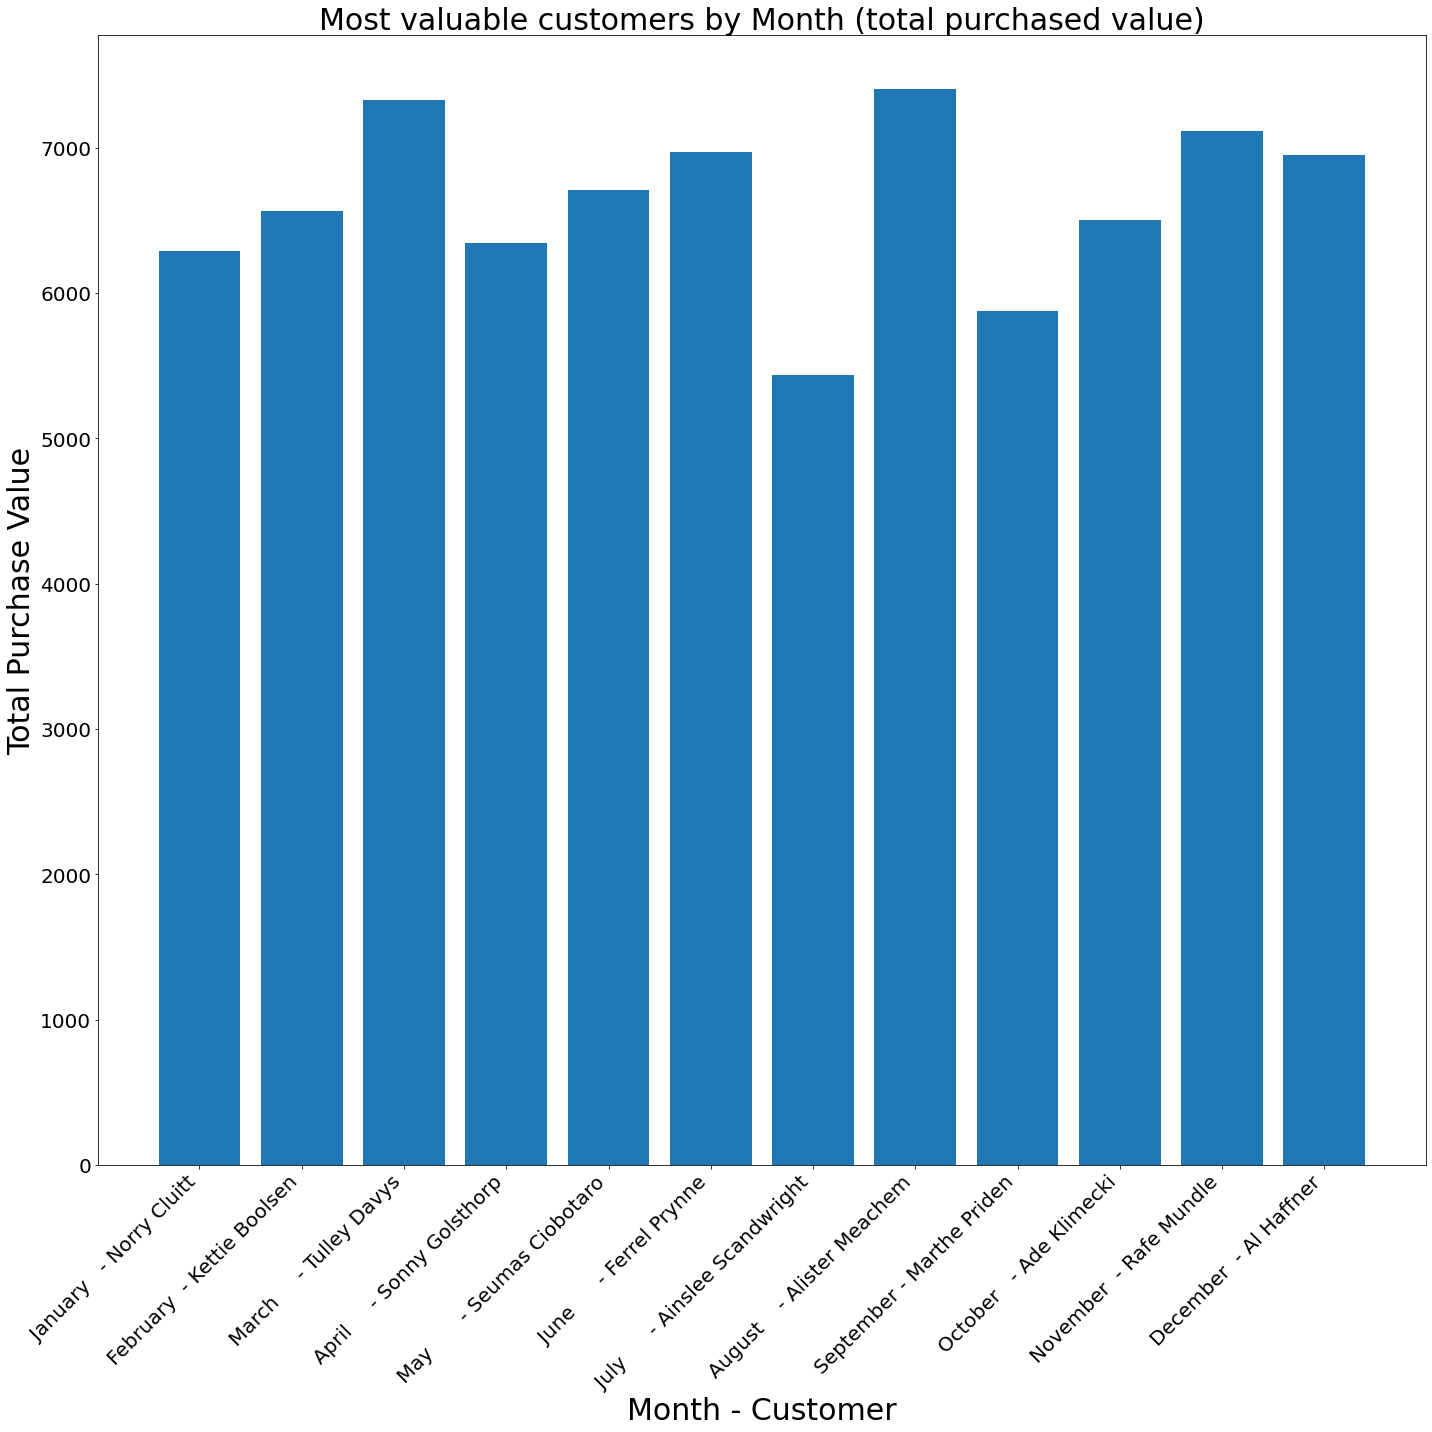

In [6]:
#Most valuable customer per month based on the total purchase value. 

import pandas as pd
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(20, 20))
plt.bar(top_customer_per_month['month'].astype(str) + ' - ' + top_customer_per_month['first_name'] + ' ' + top_customer_per_month['last_name'],
        top_customer_per_month['total_purchased_value'])
plt.xlabel('Month - Customer', size=30)
plt.ylabel('Total Purchase Value', size=30)
plt.title('Most valuable customers by Month (total purchased value)', size=30)
plt.xticks(rotation=45, ha='right', size=20)
plt.yticks(size=20)

# Show the bar chart
plt.tight_layout()
plt.show()


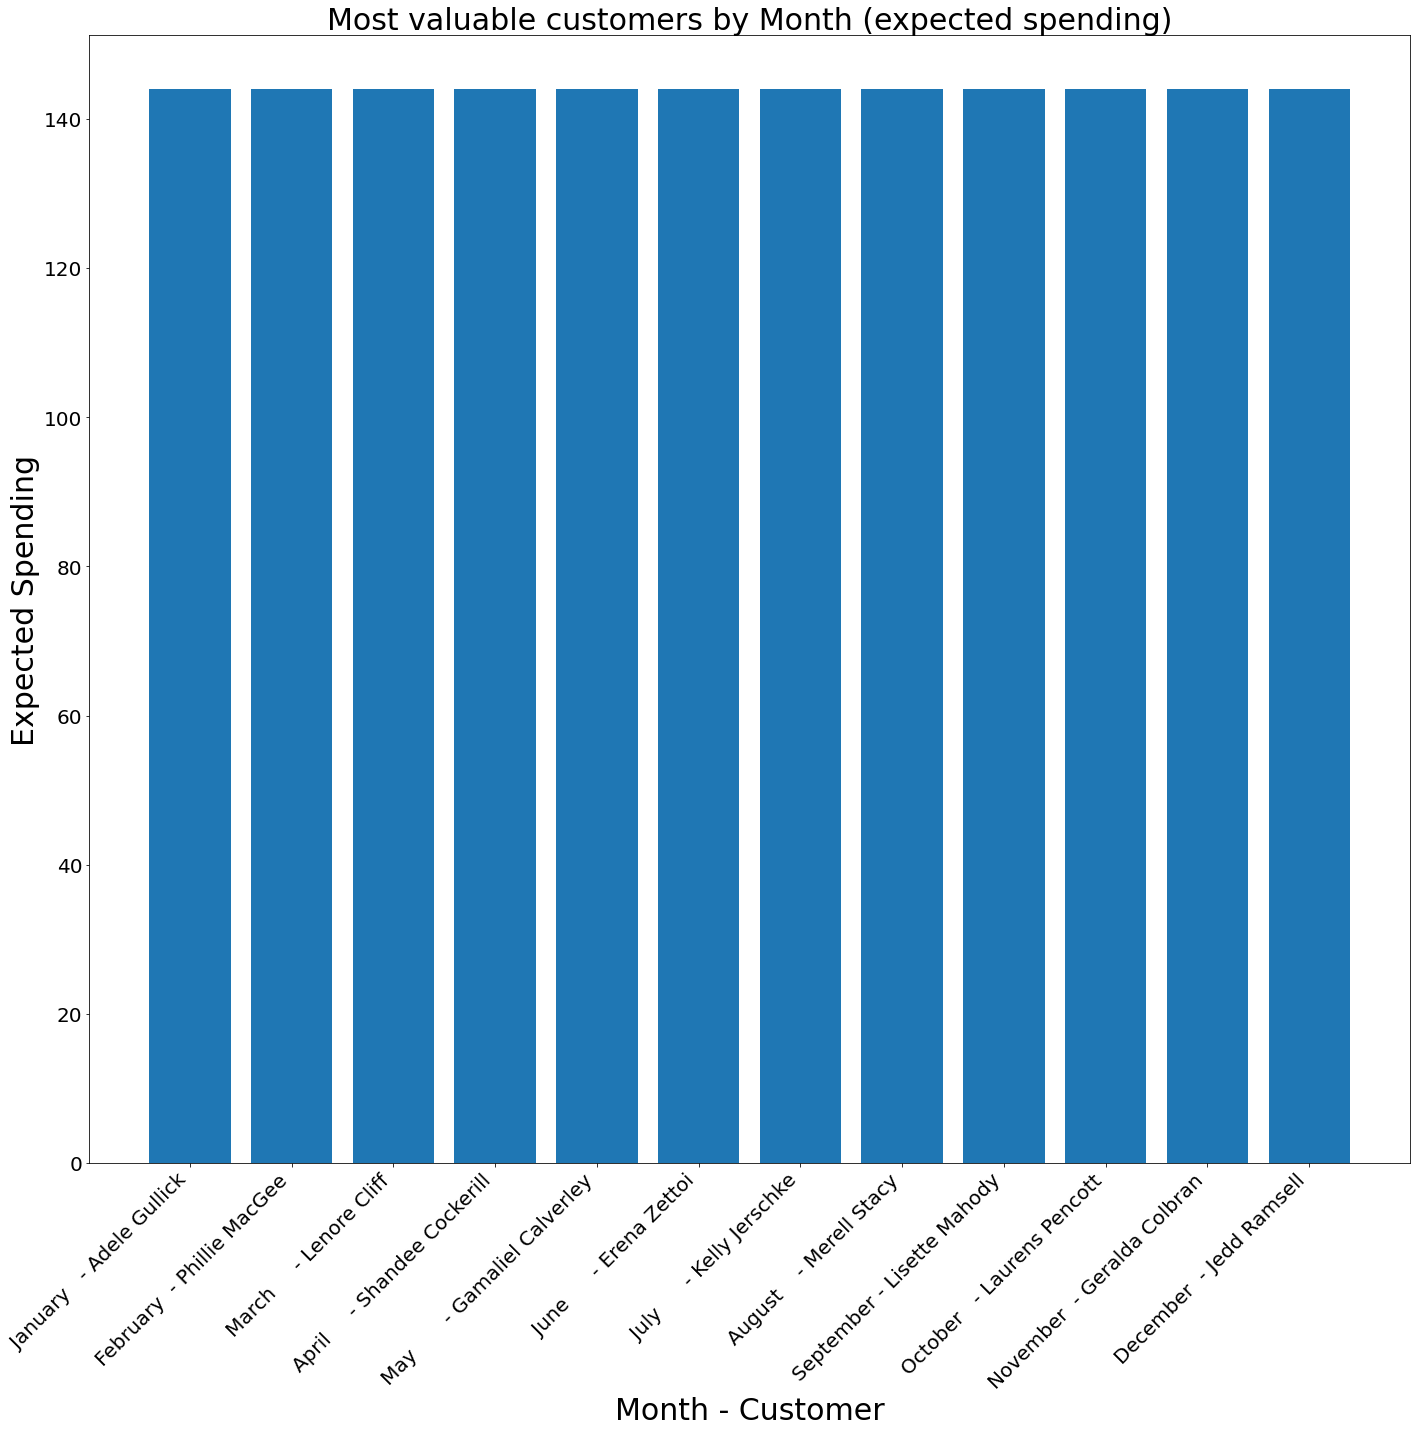

In [7]:
#Most valuable customer per month based on their expected spending per month. 

import pandas as pd
import matplotlib.pyplot as plt

monthly_customer = df[['month_number', 'month', 'store_name', 'customer_id', 'expected_spending_per_month', 'first_name', 'last_name']]

# Find the top customer per month based on total purchase amount
top_customer_per_month = monthly_customer.sort_values(by=['month_number', 'expected_spending_per_month'], ascending=[True, False]) \
    .groupby('month_number').head(1)

# Create a bar chart
plt.figure(figsize=(20, 20))
plt.bar(top_customer_per_month['month'].astype(str) + ' - ' + top_customer_per_month['first_name'] + ' ' + top_customer_per_month['last_name'],
        top_customer_per_month['expected_spending_per_month'])
plt.xlabel('Month - Customer', size=30)
plt.ylabel('Expected Spending', size=30)
plt.title('Most valuable customers by Month (expected spending)', size=30)
plt.xticks(rotation=45, ha='right', size=20)
plt.yticks(size=20)

# Show the bar chart
plt.tight_layout()
plt.show()

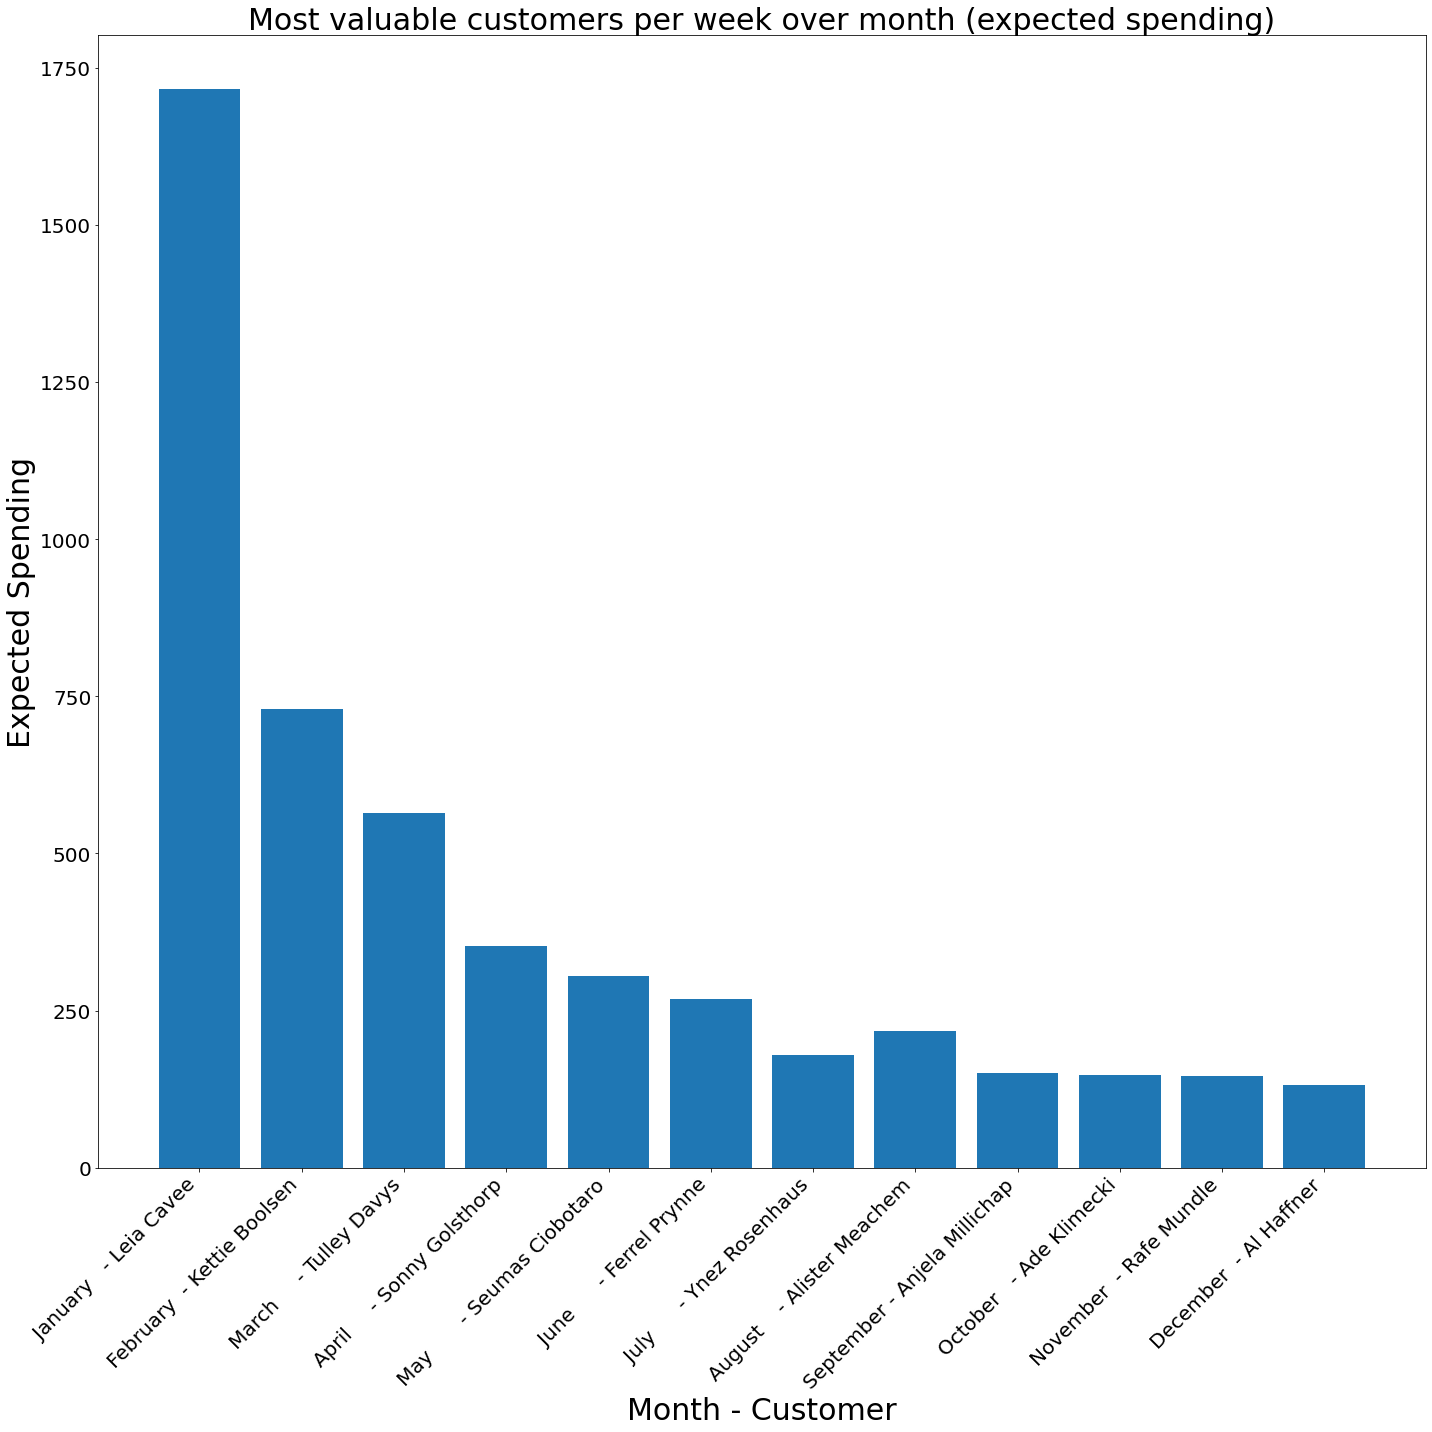

In [10]:
#Most valuable customer per month based on their expected spending per week. 

import pandas as pd
import matplotlib.pyplot as plt

weekly_customer = df[['month_number', 'month', 'store_name', 'customer_id', 'expected_spending_per_week', 'first_name', 'last_name']]

# Find the top customer per month based on total purchase amount
top_customer_per_week = weekly_customer.sort_values(by=['month_number', 'expected_spending_per_week'], ascending=[True, False]) \
    .groupby('month_number').head(1)

# Create a bar chart
plt.figure(figsize=(20, 20))
plt.bar(top_customer_per_week['month'].astype(str) + ' - ' + top_customer_per_week['first_name'] + ' ' + top_customer_per_week['last_name'],
        top_customer_per_week['expected_spending_per_week'])
plt.xlabel('Month - Customer', size=30)
plt.ylabel('Expected Spending', size=30)
plt.title('Most valuable customers per week over month (expected spending)', size=30)
plt.xticks(rotation=45, ha='right', size=20)
plt.yticks(size=20)

# Show the bar chart
plt.tight_layout()
plt.show()

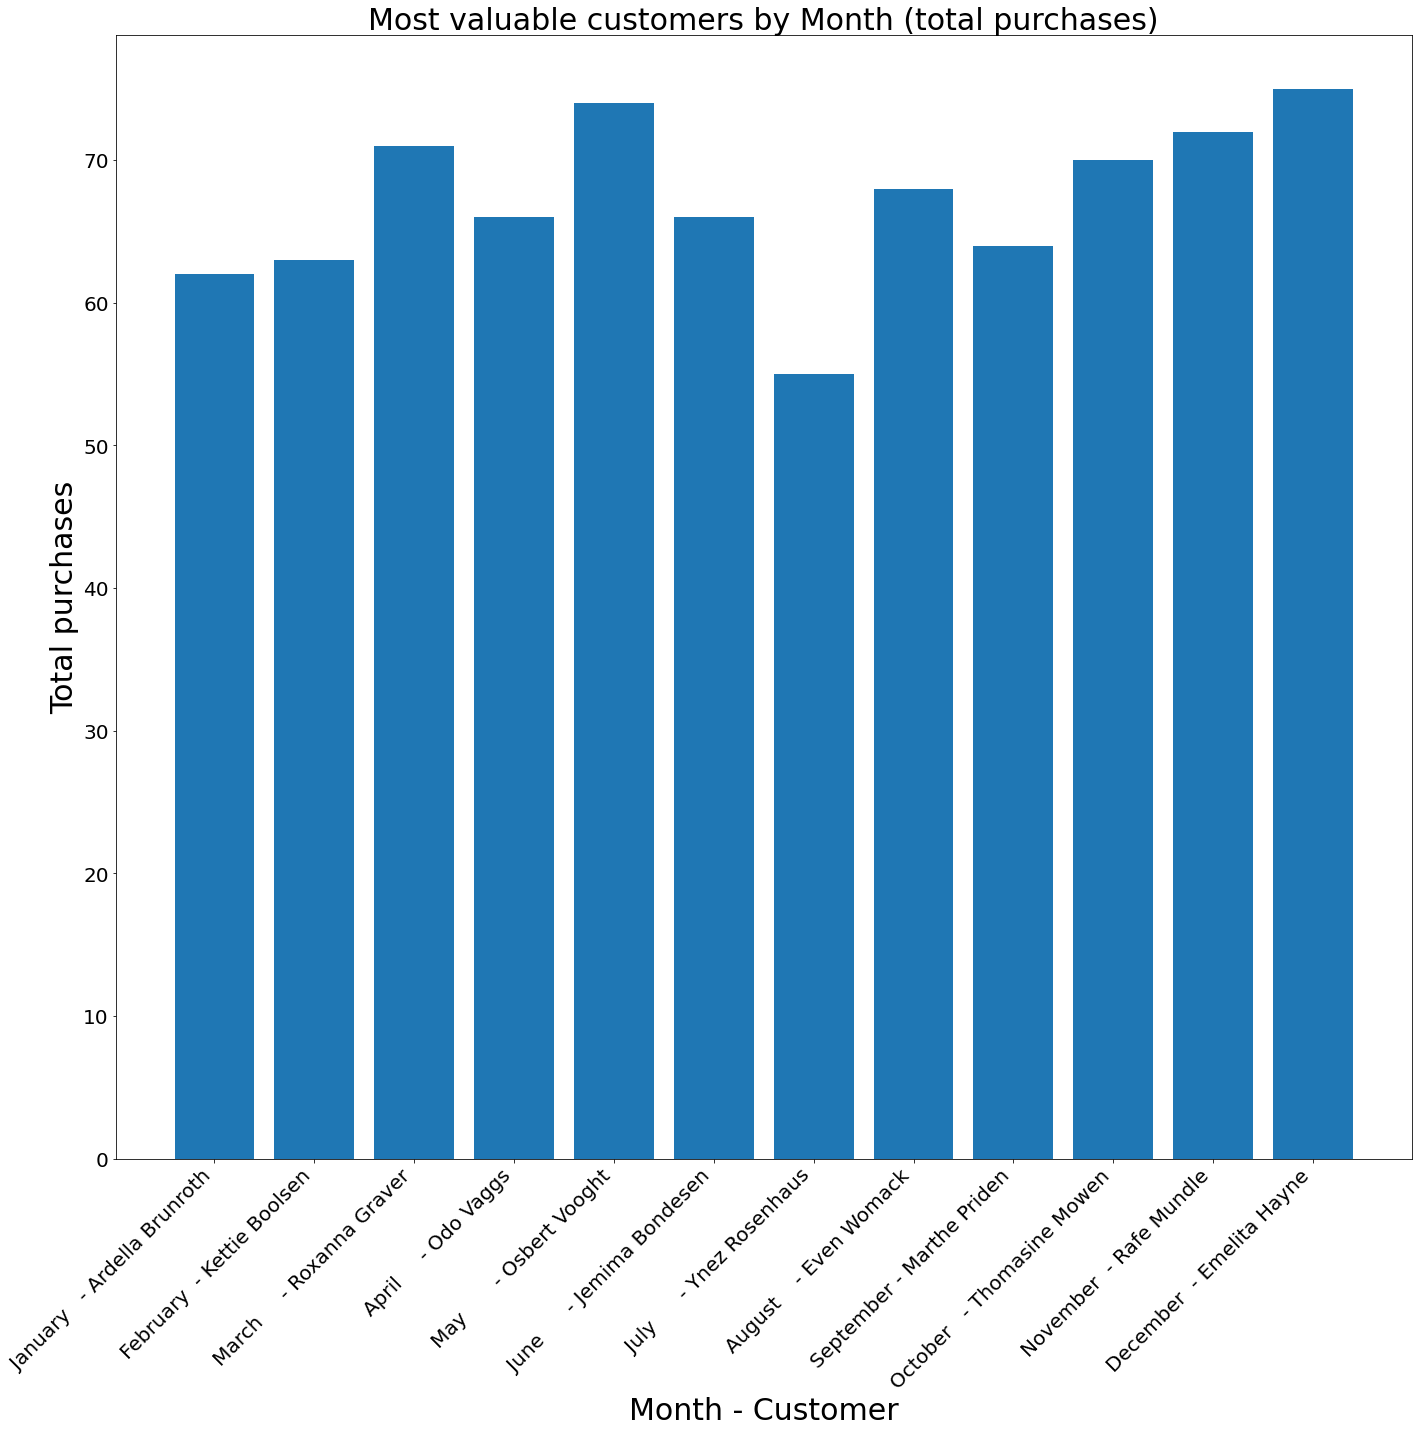

In [11]:
#Most valuable customer per month based on their purchasing frequencies. 

import pandas as pd
import matplotlib.pyplot as plt

monthly_customer = df[['month_number', 'month', 'store_name', 'customer_id', 'total_purchases', 'first_name', 'last_name']]

# Find the top customer per month based on total purchase amount
top_customer_per_month = monthly_customer.sort_values(by=['month_number', 'total_purchases'], ascending=[True, False]) \
    .groupby('month_number').head(1)

# Create a bar chart
plt.figure(figsize=(20, 20))
plt.bar(top_customer_per_month['month'].astype(str) + ' - ' + top_customer_per_month['first_name'] + ' ' + top_customer_per_month['last_name'],
        top_customer_per_month['total_purchases'])
plt.xlabel('Month - Customer', size=30)
plt.ylabel('Total purchases', size=30)
plt.title('Most valuable customers by Month (total purchases)', size=30)
plt.xticks(rotation=45, ha='right', size=20)
plt.yticks(size=20)

# Show the bar chart
plt.tight_layout()
plt.show()

Report the top 10 customers who purchased the most at a given store in a given month.  

In [16]:


# Group by store and customer, summing the total purchased amount
grouped = df[['month_number', 'month', 'store_name', 'customer_id', 'first_name', 'last_name','total_purchased_value']]

# Sort the data within each store by total purchased amount in descending order
grouped['rank'] = grouped.groupby(['month_number', 'month', 'store_name'])['total_purchased_value'].rank(method='first', ascending=False)

# Select the top 10 customers for each store
top_10_customers = grouped[grouped['rank'] <= 10]

# Drop the 'rank' column if you don't need it in the final result
top_10_customers = top_10_customers.drop(columns=['rank'])

top_10_customers

# You now have a DataFrame with the top 10 customers per store based on total purchased amount


/tmp/ipykernel_24/3659877641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped['rank'] = grouped.groupby(['month_number', 'month', 'store_name'])['total_purchased_value'].rank(method='first', ascending=False)


,month_number,month,store_name,customer_id,first_name,last_name,total_purchased_value
0,1,January,Seattle,9245,Norry,Cluitt,6288
1,1,January,Miami,23495,Liv,Rudge,6048
2,1,January,Berkeley,204,Fonzie,Cuddehy,5532
3,1,January,Miami,24033,Ardella,Brunroth,5400
4,1,January,Nashville,28619,Jareb,McClymont,5148
...,...,...,...,...,...,...,...
328207,12,December,Berkeley,311,Britteny,Flather,4404
328208,12,December,Miami,23641,Jamison,Eate,4392
328209,12,December,Berkeley,715,Sherilyn,Yerill,4380
328210,12,December,Dallas,15726,Mac,Snoxill,4380
